In this project, we will train a GNN to perform link prediction on a heterogenous graph from the Spotify Million Playlists dataset.

# Import libraries

In [ ]:
import sys  
sys.path.insert(0, '/home/yon/jupyter-server/mlg/src/')

import loader
import config
import model as M
import preprocessing
from pprint import pprint
import torch
import random
import torch_geometric
import numpy as np
import time
import matplotlib.pyplot as plt

# Model

In [ ]:
from torcheval.metrics import BinaryAccuracy

class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.conv1 = torch_geometric.nn.SAGEConv((-1, -1), hidden_channels, normalize=True)
        self.conv2 = torch_geometric.nn.SAGEConv((-1, -1), hidden_channels, normalize=True)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

class LinkPredictor(torch.nn.Module):
    def forward(self, x_track, x_playlist, track_playlist_edge):
        track_embedding = x_track[track_playlist_edge[0]]
        playlist_embedding = x_playlist[track_playlist_edge[1]]

        #print(playlist_embedding)

        # Apply dot-product to get a prediction per supervision edge:
        return (playlist_embedding * track_embedding).sum(dim=-1)

class HeteroModel(torch.nn.Module):
    def __init__(self, hidden_channels, node_features, metadata):
        super().__init__()
        # Since the dataset does not come with rich features, we also learn two
        # embedding matrices for users and movies:

        self.node_lin = {
            k: torch.nn.Linear(v.shape[1], hidden_channels) for k, v in node_features.items()
        }

        for _, v in self.node_lin.items():
            torch.nn.init.xavier_uniform_(v.weight)
        
        # Instantiate homogeneous GNN:
        self.gnn = GNN(hidden_channels)
        # Convert GNN model into a heterogeneous variant:
        self.gnn = torch_geometric.nn.to_hetero(self.gnn, metadata=metadata)

        self.classifier = LinkPredictor()

    def forward(self, data):
        x_dict = {
            k: self.node_lin[k](v) for k, v in data.x_dict.items()
        }

        x_dict = self.gnn(x_dict, data.edge_index_dict)
        pred = self.classifier(
            x_dict["track"],
            x_dict["playlist"],
            data["track", "contains", "playlist"].edge_label_index,
        )
        return pred

    def reset_parameters(self):
        for _, v in self.node_lin.items():
            torch.nn.init.xavier_uniform_(v.weight)
        self.gnn.reset_parameters()

def dummy_generator(source):
    for e in source:
        yield e

def train(model, train_loader, optimizer, batch_wrapper=dummy_generator):
    model.train()

    accuracy = 0

    total_examples = total_loss = 0
    for i, batch in enumerate(batch_wrapper(train_loader)):
        optimizer.zero_grad()
        
        out = model(batch)
        truth = batch["track", "contains", "playlist"].edge_label


        ind = torch.randint(len(out),(5,))

        print(out[ind])
        print(truth[ind])

        if(i % 10 == 0):
            #print(out[:10])
            #print(batch["track", "contains", "playlist"].edge_label[:10])
            pass
        loss = torch.nn.functional.mse_loss(
            out, truth
        )
        loss.backward()
        optimizer.step()

        metric = BinaryAccuracy()
        metric.update(out, truth)
        accuracy += metric.compute() * len(out)

        total_examples += len(out)
        total_loss += float(loss) * len(out)

    return total_loss / total_examples, accuracy / total_examples

# Test Run

In [ ]:
!rm spotify_million_playlist_dataset/pickles/G_example.pkl

In [ ]:
ghetero = loader.get_ghetero(True, config)
data_train, data_val, data_test = loader.get_datasets(True, config)

In [ ]:
# create training mask for playlist nodes
train_mask = torch.zeros(ghetero["playlist"].x.shape[0], dtype=torch.bool)
train_mask[torch.randperm(train_mask.shape[0])[:int(train_mask.shape[0]*0.8)]] = True

ghetero["playlist"].train_mask = train_mask

ghetero["playlist"].y = torch.LongTensor([1]*ghetero["playlist"].x.shape[0])

model = HeteroModel(64, ghetero.x_dict, ghetero.metadata())
optimizer = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=0.0001)

edge_label_index = data_train["track", "contains", "playlist"].edge_label_index
edge_label = data_train["track", "contains", "playlist"].edge_label
train_loader = torch_geometric.loader.LinkNeighborLoader(
    data=data_train,
    num_neighbors=[20, 10],
    neg_sampling_ratio=2.0,
    edge_label_index=(("track", "contains", "playlist"), edge_label_index),
    edge_label=edge_label,
    batch_size=128,
    shuffle=True,
)

In [ ]:
data_train

 58%|████████████████████████████████████████▉                              | 72/125 [00:02<00:02, 24.93it/s]

tensor([0.3750, 0.3662, 0.3816, 0.1446, 0.5960], grad_fn=<SliceBackward0>)
tensor([1., 1., 1., 1., 1.])
tensor([0.1992, 0.1685, 0.5131, 0.5703, 0.3960], grad_fn=<SliceBackward0>)
tensor([1., 1., 1., 1., 1.])
tensor([0.3947, 0.5004, 0.2134, 0.4695, 0.6114], grad_fn=<SliceBackward0>)
tensor([1., 1., 1., 1., 1.])
tensor([0.3920, 0.2098, 0.3707, 0.3833, 0.4864], grad_fn=<SliceBackward0>)
tensor([1., 1., 1., 1., 1.])
tensor([0.4408, 0.2041, 0.4373, 0.4451, 0.2018], grad_fn=<SliceBackward0>)
tensor([1., 1., 1., 1., 1.])


 62%|████████████████████████████████████████████▎                          | 78/125 [00:03<00:01, 24.80it/s]

tensor([0.5524, 0.5033, 0.4474, 0.2355, 0.4444], grad_fn=<SliceBackward0>)
tensor([1., 1., 1., 1., 1.])
tensor([0.1784, 0.1774, 0.4460, 0.3866, 0.4394], grad_fn=<SliceBackward0>)
tensor([1., 1., 1., 1., 1.])
tensor([0.2579, 0.4547, 0.3015, 0.2520, 0.2824], grad_fn=<SliceBackward0>)
tensor([1., 1., 1., 1., 1.])
tensor([0.2311, 0.4808, 0.4790, 0.4165, 0.3404], grad_fn=<SliceBackward0>)
tensor([1., 1., 1., 1., 1.])
tensor([0.3964, 0.2738, 0.2673, 0.3435, 0.3942], grad_fn=<SliceBackward0>)
tensor([1., 1., 1., 1., 1.])


 65%|██████████████████████████████████████████████                         | 81/125 [00:03<00:01, 24.81it/s]

tensor([0.1732, 0.5817, 0.2712, 0.3862, 0.2859], grad_fn=<SliceBackward0>)
tensor([1., 1., 1., 1., 1.])
tensor([0.4130, 0.2108, 0.4208, 0.3669, 0.1776], grad_fn=<SliceBackward0>)
tensor([1., 1., 1., 1., 1.])
tensor([0.1650, 0.5099, 0.3373, 0.4894, 0.4570], grad_fn=<SliceBackward0>)
tensor([1., 1., 1., 1., 1.])
tensor([0.3814, 0.3621, 0.3758, 0.4898, 0.4129], grad_fn=<SliceBackward0>)
tensor([1., 1., 1., 1., 1.])
tensor([0.3560, 0.4385, 0.3821, 0.4499, 0.4640], grad_fn=<SliceBackward0>)
tensor([1., 1., 1., 1., 1.])
tensor([0.3606, 0.4053, 0.3558, 0.3519, 0.3375], grad_fn=<SliceBackward0>)
tensor([1., 1., 1., 1., 1.])


 70%|█████████████████████████████████████████████████▍                     | 87/125 [00:03<00:01, 24.72it/s]

tensor([0.4584, 0.5027, 0.6118, 0.5276, 0.3860], grad_fn=<SliceBackward0>)
tensor([1., 1., 1., 1., 1.])
tensor([0.2224, 0.0761, 0.1981, 0.1135, 0.0788], grad_fn=<SliceBackward0>)
tensor([1., 1., 1., 1., 1.])
tensor([0.4438, 0.4096, 0.4067, 0.4780, 0.3979], grad_fn=<SliceBackward0>)
tensor([1., 1., 1., 1., 1.])
tensor([0.7312, 0.6019, 0.4199, 0.4588, 0.4929], grad_fn=<SliceBackward0>)
tensor([1., 1., 1., 1., 1.])
tensor([0.2446, 0.3687, 0.3432, 0.3636, 0.3654], grad_fn=<SliceBackward0>)
tensor([1., 1., 1., 1., 1.])
tensor([0.1458, 0.2294, 0.2963, 0.1490, 0.2900], grad_fn=<SliceBackward0>)


 74%|████████████████████████████████████████████████████▊                  | 93/125 [00:03<00:01, 24.88it/s]

tensor([1., 1., 1., 1., 1.])
tensor([0.3251, 0.2771, 0.3420, 0.3440, 0.6328], grad_fn=<SliceBackward0>)
tensor([1., 1., 1., 1., 1.])
tensor([0.6583, 0.2956, 0.6215, 0.3288, 0.2958], grad_fn=<SliceBackward0>)
tensor([1., 1., 1., 1., 1.])
tensor([0.2646, 0.1358, 0.2642, 0.1763, 0.2422], grad_fn=<SliceBackward0>)
tensor([1., 1., 1., 1., 1.])
tensor([0.7657, 1.0528, 0.6223, 0.9340, 0.6164], grad_fn=<SliceBackward0>)
tensor([1., 1., 1., 1., 1.])
tensor([-0.0355,  0.0773, -0.0871,  0.1083,  0.1371], grad_fn=<SliceBackward0>)
tensor([1., 1., 1., 1., 1.])


 79%|████████████████████████████████████████████████████████▏              | 99/125 [00:03<00:01, 25.06it/s]

tensor([-0.0180, -0.0060,  0.1545,  0.0198,  0.1437], grad_fn=<SliceBackward0>)
tensor([1., 1., 1., 1., 1.])
tensor([0.5932, 0.6368, 0.5361, 0.5805, 0.6522], grad_fn=<SliceBackward0>)
tensor([1., 1., 1., 1., 1.])
tensor([0.5262, 0.5574, 0.4622, 0.4858, 0.5668], grad_fn=<SliceBackward0>)
tensor([1., 1., 1., 1., 1.])
tensor([-0.0421, -0.0056, -0.1265,  0.1175, -0.1069], grad_fn=<SliceBackward0>)
tensor([1., 1., 1., 1., 1.])
tensor([0.5869, 0.5493, 0.5895, 0.5699, 0.5376], grad_fn=<SliceBackward0>)
tensor([1., 1., 1., 1., 1.])
tensor([0.4456, 0.4420, 0.5382, 0.5066, 0.4133], grad_fn=<SliceBackward0>)
tensor([1., 1., 1., 1., 1.])


 84%|██████████████████████████████████████████████████████████▊           | 105/125 [00:04<00:00, 25.05it/s]

tensor([0.2197, 0.2057, 0.2042, 0.2652, 0.3114], grad_fn=<SliceBackward0>)
tensor([1., 1., 1., 1., 1.])
tensor([0.1545, 0.1973, 0.1107, 0.0340, 0.0569], grad_fn=<SliceBackward0>)
tensor([1., 1., 1., 1., 1.])
tensor([0.2863, 0.2960, 0.2741, 0.3105, 0.2827], grad_fn=<SliceBackward0>)
tensor([1., 1., 1., 1., 1.])
tensor([0.3822, 0.4301, 0.4729, 0.4558, 0.4761], grad_fn=<SliceBackward0>)
tensor([1., 1., 1., 1., 1.])
tensor([0.5080, 0.5149, 0.4907, 0.4590, 0.5403], grad_fn=<SliceBackward0>)
tensor([1., 1., 1., 1., 1.])


 89%|██████████████████████████████████████████████████████████████▏       | 111/125 [00:04<00:00, 24.24it/s]

tensor([0.4057, 0.4367, 0.3263, 0.4163, 0.4169], grad_fn=<SliceBackward0>)
tensor([1., 1., 1., 1., 1.])
tensor([0.1827, 0.2691, 0.2705, 0.2750, 0.2443], grad_fn=<SliceBackward0>)
tensor([1., 1., 1., 1., 1.])
tensor([0.2435, 0.2746, 0.2430, 0.2418, 0.2253], grad_fn=<SliceBackward0>)
tensor([1., 1., 1., 1., 1.])
tensor([0.3571, 0.3409, 0.3243, 0.2961, 0.3359], grad_fn=<SliceBackward0>)
tensor([1., 1., 1., 1., 1.])
tensor([0.4331, 0.4411, 0.4329, 0.4142, 0.3713], grad_fn=<SliceBackward0>)
tensor([1., 1., 1., 1., 1.])


 91%|███████████████████████████████████████████████████████████████▊      | 114/125 [00:04<00:00, 24.39it/s]

tensor([0.3634, 0.4707, 0.4821, 0.4461, 0.4501], grad_fn=<SliceBackward0>)
tensor([1., 1., 1., 1., 1.])
tensor([0.4180, 0.4092, 0.4485, 0.4018, 0.3020], grad_fn=<SliceBackward0>)
tensor([1., 1., 1., 1., 1.])
tensor([0.3214, 0.3231, 0.3352, 0.3106, 0.3250], grad_fn=<SliceBackward0>)
tensor([1., 1., 1., 1., 1.])
tensor([0.2310, 0.3599, 0.3504, 0.3725, 0.2409], grad_fn=<SliceBackward0>)
tensor([1., 1., 1., 1., 1.])
tensor([0.4151, 0.3847, 0.4031, 0.4906, 0.3867], grad_fn=<SliceBackward0>)
tensor([1., 1., 1., 1., 1.])
tensor([0.4050, 0.3826, 0.4093, 0.4698, 0.2501], grad_fn=<SliceBackward0>)
tensor([1., 1., 1., 1., 1.])


 94%|██████████████████████████████████████████████████████████████████    | 118/125 [00:04<00:00, 24.50it/s]


tensor([0.2166, 0.3393, 0.2892, 0.3508, 0.3315], grad_fn=<SliceBackward0>)
tensor([1., 1., 1., 1., 1.])
tensor([0.3758, 0.2162, 0.2274, 0.3131, 0.3785], grad_fn=<SliceBackward0>)
tensor([1., 1., 1., 1., 1.])


KeyboardInterrupt: 

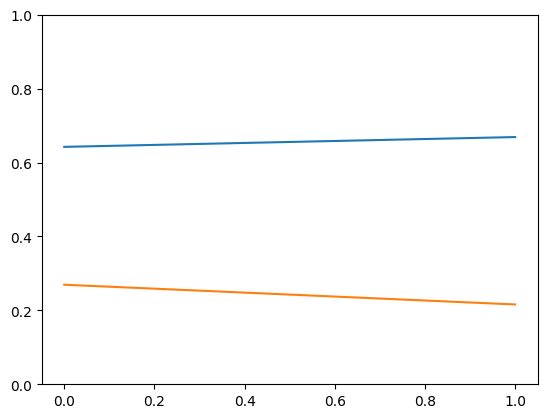

In [126]:
import tqdm
epoch = 100

render_graph = True

losses = []
accuracies = []


for i in range(epoch):
    loss, accuracy = train(model, train_loader, optimizer, batch_wrapper=tqdm.tqdm)
    losses.append(loss)
    accuracies.append(accuracy)
    print(f"Epoch {i+1}/{epoch}, Loss: {loss:.4f}, Accuracy {accuracy:.4f}")

    plt.clf()
    plt.plot(np.arange(len(accuracies)), accuracies)
    plt.plot(np.arange(len(losses)), losses)

    #start plot at 0
    plt.ylim(0, 1)

    if render_graph and i % 10 == 0 and i != 0:
        plt.show()

